## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

### Application de la version Tri_bas au Bonn Dataset

In [1]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [2]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [14]:
# Dossier contenant les images
repertoire = "../Bonn_Dataset"
sous_dossiers = ["tv000_pv000"]
img_width, img_height = 50, 50

# Expression pour extraire les infos du nom de fichier
pattern = re.compile(r"(\d+)\s+tl([\d.-]+)\s+pl([\d.-]+)\s+tv([\d.-]+)\s+pv([\d.-]+)\.jpg")

# Stockage des résultats
images_info = []

for dossier in sous_dossiers:
    chemin_dossier = os.path.join(repertoire, dossier)
    print(chemin_dossier)
    for nom_fichier in os.listdir(chemin_dossier):
        print(nom_fichier)
        if nom_fichier.endswith(".jpg"):
            match = pattern.match(nom_fichier)
            if match:
                i, tl, pl, tv, pv = match.groups()
                tl, pl = int(tl), int(pl)
                px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
                chemin_image = os.path.join(chemin_dossier, nom_fichier)
                image = Image.open(chemin_image)
                w, h = image.size
                left = (w - img_width) / 2
                top = (h - img_height) / 2
                right = (w + img_width) / 2
                bottom = (h + img_height) / 2
                image = Image.open(chemin_image).crop((left, top, right, bottom))
                pixels = np.array(image, dtype=np.float32) / 255.0

                images_info.append({
                    "tl": tl,
                    "pl": pl,
                    "px": px,
                    "py": py,
                    "image": image,
                    "pixels": pixels,
                })
            else:
                print(f"Nom de fichier ignoré : {nom_fichier}")

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

../Bonn_Dataset/tv000_pv000
03321 tl060 pl072 tv000 pv000.jpg
05427 tl075 pl150 tv000 pv000.jpg
00243 tl015 pl120 tv000 pv000.jpg
02673 tl045 pl280 tv000 pv000.jpg
03888 tl060 pl198 tv000 pv000.jpg
04374 tl060 pl306 tv000 pv000.jpg
03483 tl060 pl108 tv000 pv000.jpg
03726 tl060 pl162 tv000 pv000.jpg
01701 tl045 pl040 tv000 pv000.jpg
01782 tl045 pl060 tv000 pv000.jpg
03159 tl060 pl036 tv000 pv000.jpg
03564 tl060 pl126 tv000 pv000.jpg
03645 tl060 pl144 tv000 pv000.jpg
04779 tl075 pl030 tv000 pv000.jpg
06075 tl075 pl270 tv000 pv000.jpg
06480 tl075 pl345 tv000 pv000.jpg
01539 tl045 pl000 tv000 pv000.jpg
04860 tl075 pl045 tv000 pv000.jpg
01458 tl030 pl330 tv000 pv000.jpg
02106 tl045 pl140 tv000 pv000.jpg
06399 tl075 pl330 tv000 pv000.jpg
03078 tl060 pl018 tv000 pv000.jpg
03807 tl060 pl180 tv000 pv000.jpg
01377 tl030 pl300 tv000 pv000.jpg
05589 tl075 pl180 tv000 pv000.jpg
02268 tl045 pl180 tv000 pv000.jpg
01863 tl045 pl080 tv000 pv000.jpg
02349 tl045 pl200 tv000 pv000.jpg
00729 tl030 pl060 tv

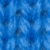

In [15]:
images_info[2]['image']

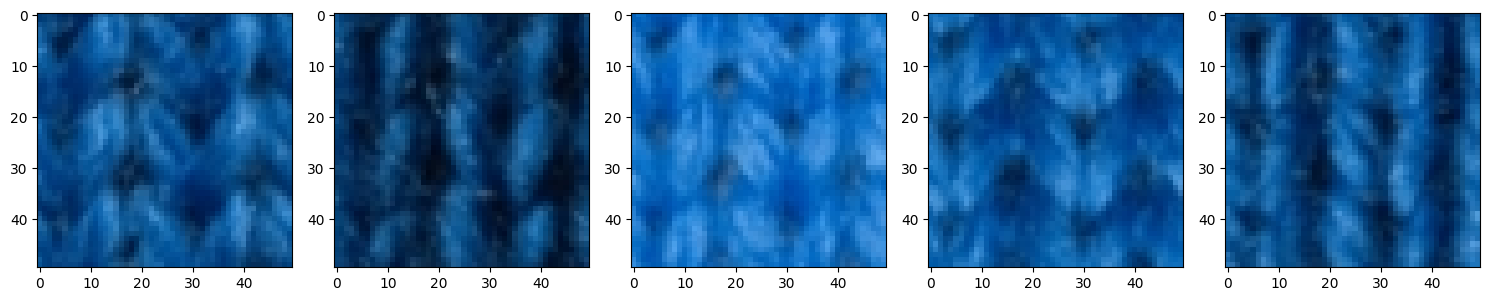

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [17]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

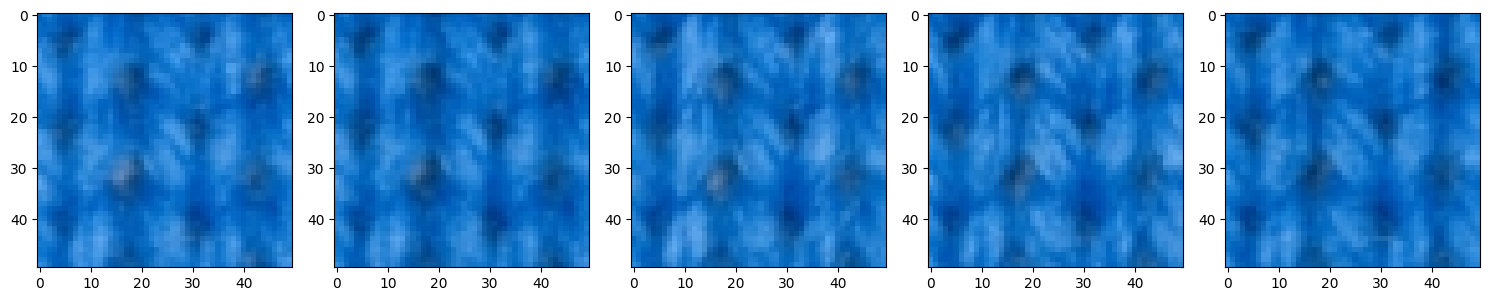

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

# Cette fois ci visualisation de l'oraganisation des texels en fonctin des positions stéréo

In [19]:
# On prend le pixel le plus au centre
texel_row = img_height // 2
texel_col = img_width // 2
texel_position_str = f"({texel_row}, {texel_col})" # Pour l'affichage
print(texel_position_str)

(25, 25)


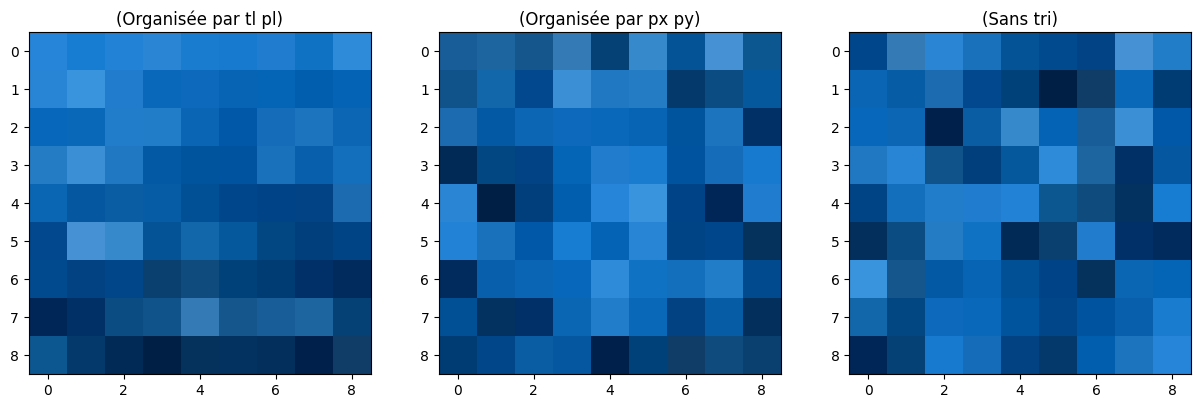

In [20]:
# Visualiser l'organisation de la matrice 9*9 en fonction du tri
# D'abord tl pl puis px, py
texel_angles = []
texel_stereo = []
texel_sans = []

images_angles = copy.deepcopy(images_info) # Copie pour le tri par angles
images_stereo = copy.deepcopy(images_info) # Copie pour le tri par stéréographiques


# Appliquer les tris aux copies distinctes
images_angles.sort(key=lambda d: (d["tl"], d["pl"]))
images_stereo.sort(key=lambda d: (d["px"], d["py"]))


for ang, ste, sans in zip(images_angles, images_stereo, images_info):
    # info["pixels"] est le tableau NumPy 30x30x3 pour l'image entière de cette configuration angulaire
    texel_rgb_a = ang["pixels"][texel_row, texel_col, :]
    texel_rgb_s = ste["pixels"][texel_row, texel_col, :]
    texel_rgb = sans["pixels"][texel_row, texel_col, :]
    texel_angles.append(texel_rgb_a)
    texel_stereo.append(texel_rgb_s)
    texel_sans.append(texel_rgb)

# Convertir la liste en tableau NumPy
texel_angles_np = np.array(texel_angles, dtype=np.float32) # Forme (81, 3)
texel_stereo_np = np.array(texel_stereo, dtype=np.float32) # Forme (81, 3)
texel_sans_np = np.array(texel_sans, dtype=np.float32) # Forme (81, 3)

# Remodeler en matrice 9x9x3
mat_a = (texel_angles_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)
mat_s = (texel_stereo_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)
mat = (texel_sans_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mat_a)
axes[1].imshow(mat_s)
axes[2].imshow(mat)
axes[0].set_title(f"(Organisée par tl pl)")
axes[1].set_title(f"(Organisée par px py)")
axes[2].set_title(f"(Sans tri)")
plt.show()


In [21]:
images_info[0]['pixels'][0, 0], sorted[0]['pixels'][0, 0]

(array([0.        , 0.23137255, 0.45882353], dtype=float32),
 array([0.        , 0.39215687, 0.7529412 ], dtype=float32))

In [22]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.        0.3647059 0.7176471]
Nombre d'images importées: 81


# Création du modèles

In [44]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light_ang = Model(inputs=i, outputs=latent_output, name="EncoderLight_ang")
#encoder_model_light_ang.summary()

# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input_ang = Input(shape=(input_dim,), name='decoder_input_ang')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input_ang)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model_ang = Model(inputs=decoder_input_ang, outputs=decoder_output, name="Decoder_ang")
#decoder_model_ang.summary()

# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light_ang(i)
decoder_input_ang = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model_ang(decoder_input_ang)

vae_ang = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE_ang')
vae_ang.summary()

Model: "VAE_ang"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight_ang    │ (None, 8)         │     10,248 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 10)        │          0 │ EncoderLight_ang… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_ang         │ (None, 3)         │     35,513 │ concatenate_3[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 128 (512.00 B)

In [45]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light_ste = Model(inputs=i, outputs=latent_output, name="EncoderLight_ste")
#encoder_model_light_ste.summary()

# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input_ste = Input(shape=(input_dim,), name='decoder_input_ste')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input_ste)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model_ste = Model(inputs=decoder_input_ste, outputs=decoder_output, name="Decoder_ste")
#decoder_model_ste.summary()

# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light_ste(i)
decoder_input_ste = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model_ste(decoder_input_ste)

vae_ste = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE_ste')
vae_ste.summary()

Model: "VAE_ste"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight_ste    │ (None, 8)         │     10,248 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 10)        │          0 │ EncoderLight_ste… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_ste         │ (None, 3)         │     35,513 │ concatenate_4[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 128 (512.00 B)

In [46]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light = Model(inputs=i, outputs=latent_output, name="EncoderLight")
#encoder_model_light.summary()

# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
#decoder_model.summary()

# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model(decoder_input)

vae = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE')
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight        │ (None, 8)         │     10,248 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 10)        │          0 │ EncoderLight[0][… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,513 │ concatenate_5[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 128 (512.00 B)

In [47]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
## On vérifie quel tri des images est le plus efficace
Sur un seul texel 

In [48]:
# on prend toutes les images
image_stack_ang = np.stack([info["pixels"] for info in images_angles], axis=0)
image_stack_ste = np.stack([info["pixels"] for info in images_stereo], axis=0)
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [49]:
# on fait de même avec les angles
tl_stack_ang = np.stack([info["tl"] for info in images_angles], axis=0)
pl_stack_ang = np.stack([info["pl"] for info in images_angles], axis=0)
px_stack_ang = np.stack([info["px"] for info in images_angles], axis=0)
py_stack_ang = np.stack([info["py"] for info in images_angles], axis=0)

# et pour les positions stéréo
tl_stack_ste = np.stack([info["tl"] for info in images_stereo], axis=0)
pl_stack_ste = np.stack([info["pl"] for info in images_stereo], axis=0)
px_stack_ste = np.stack([info["px"] for info in images_stereo], axis=0)
py_stack_ste = np.stack([info["py"] for info in images_stereo], axis=0)

# et pour les positions non triées
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [50]:
# Préparation des données

# Choisir UN texel
texel_position = (texel_row, texel_col)

# Préparation tri selon les angles
texel_observations_ang = image_stack_ang[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations_ang = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations_ang[:len(texel_observations_ang)] = texel_observations_ang

input_train_batch_2d_ang = padded_observations_ang.reshape((1, matrix_H, matrix_W, num_channels)) # matrice input pour LE texel
target_rgb_train_ang = texel_observations_ang  # (81, 3)
light_dirs_ang = np.stack([px_stack_ang, py_stack_ang], axis=1) # Forme (81, 2)

# Préparation tri selon les positions
texel_observations_ste = image_stack_ste[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations_ste = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations_ste[:len(texel_observations_ste)] = texel_observations_ste

input_train_batch_2d_ste = padded_observations_ste.reshape((1, matrix_H, matrix_W, num_channels))
target_rgb_train_ste = texel_observations_ste  # (81, 3)
light_dirs_ste = np.stack([px_stack_ste, py_stack_ste], axis=1) # Forme (81, 2)

# Préparation sans tri
texel_observations = image_stack[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations[:len(texel_observations)] = texel_observations

input_train_batch_2d = padded_observations.reshape((1, matrix_H, matrix_W, num_channels))
target_rgb_train = texel_observations  # (81, 3)
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)

In [51]:
print(f"couleurs triées par les angles: {target_rgb_train_ang[0]}, par les coordonnées: {target_rgb_train_ste[0]}")

couleurs triées par les angles: [0.14901961 0.52156866 0.8509804 ], par les coordonnées: [0.09411765 0.3647059  0.59607846]


In [52]:
# Compilation et entraînement ang
custom_optimizer_ang = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae_ang.compile(custom_optimizer_ang, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history_vae_ang = vae_ang.fit([np.repeat(input_train_batch_2d_ang, samples, axis=0), light_dirs_ang], target_rgb_train_ang,
        epochs=50, batch_size=5, validation_split=0.2)

# Compilation et entraînement ste
custom_optimizer_ste = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae_ste.compile(custom_optimizer_ste, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history_vae_ste = vae_ste.fit([np.repeat(input_train_batch_2d_ste, samples, axis=0), light_dirs_ste], target_rgb_train_ste,
        epochs=50, batch_size=5, validation_split=0.2)

# Compilation et entraînement sans tri
custom_optimizer = Adam(learning_rate=0.001) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history_vae = vae.fit([np.repeat(input_train_batch_2d, samples, axis=0), light_dirs], target_rgb_train,
        epochs=50, batch_size=5, validation_split=0.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0537 - val_loss: 0.0517
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0502
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0495
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - val_loss: 0.0483
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0501
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - val_loss: 0.0489
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0435
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0476
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0426
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0446
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0396
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_lo

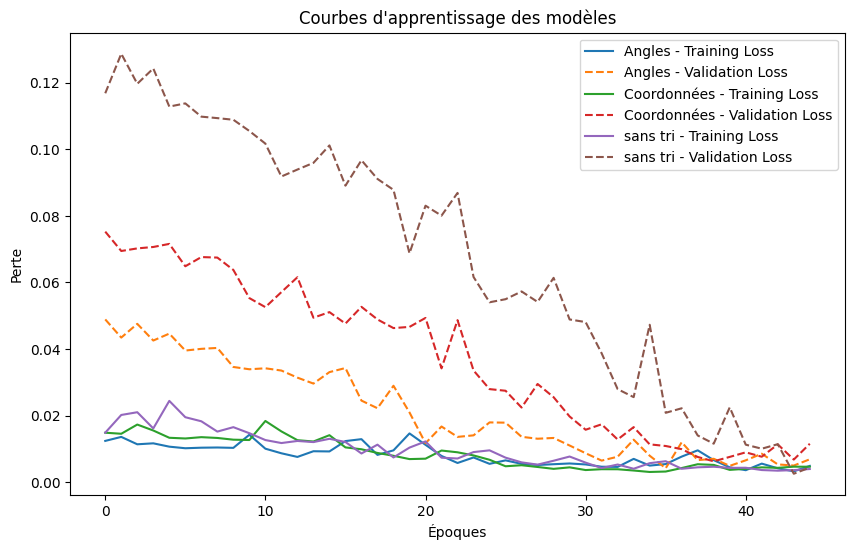

In [53]:
def plot_multiple_learning_curves(history_list, titles, start_epoch=0):
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(history_list):
        model_title = titles[i]
        
        # Vérifiez que 'loss' et 'val_loss' sont présents
        plt.plot(history.history['loss'][start_epoch:], label=f"{model_title} - Training Loss")
        plt.plot(history.history['val_loss'][start_epoch:], label=f"{model_title} - Validation Loss", linestyle='--')

    plt.title("Courbes d'apprentissage des modèles")
    plt.xlabel("Époques")
    plt.ylabel("Perte")
    plt.legend()
    plt.show()

plot_multiple_learning_curves(
    history_list=[history_vae_ang, history_vae_ste, history_vae],
    titles=["Angles", "Coordonnées", "sans tri"],
    start_epoch=5
)


# Prédicitions d'un texel avec une configuration spécifique

In [54]:
index = 3
light_direction = light_dirs_ang[index]

latent_vector = encoder_model_light_ang.predict(input_train_batch_2d_ang)[0]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model_ang.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train_ang[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted RGB: [[0.09996273 0.44334137 0.7295914 ]] Original [0.16470589 0.52156866 0.83137256]


In [55]:
index = 3
light_direction =light_dirs_ste[index]

latent_vector = encoder_model_light_ste.predict(input_train_batch_2d_ste)[0]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model_ste.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train_ste[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted RGB: [[0.10906456 0.33722478 0.58498204]] Original [0.20392157 0.47843137 0.70980394]


In [56]:
index = 3
light_direction =light_dirs[index]

latent_vector = encoder_model_light.predict(input_train_batch_2d)[0]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted RGB: [[0.02473303 0.27370092 0.47000498]] Original [0.09803922 0.44313726 0.73333335]


# Compraison des prédictions visuellement

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


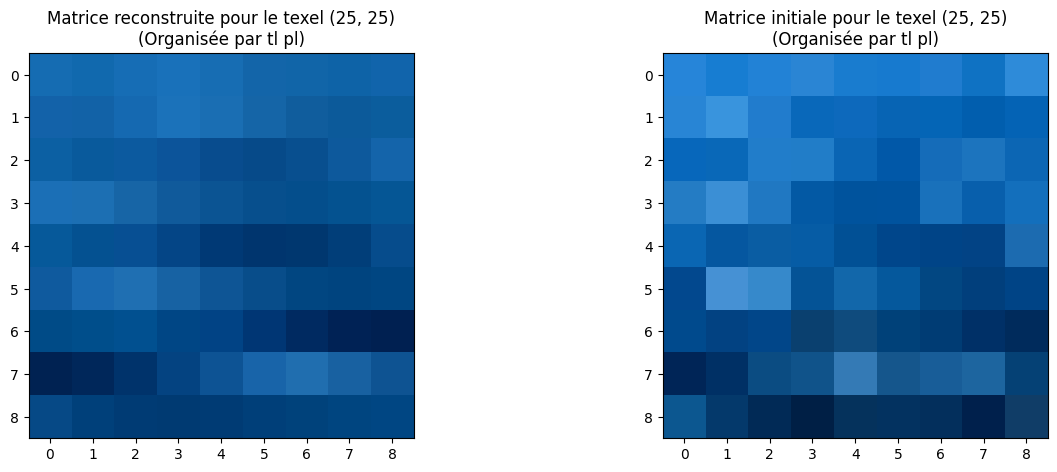

(Theta, Phi) Différence absolue entre la matrice reconstruite, et la matrice initiale: 0.022


In [57]:
latent_vector = encoder_model_light_ang.predict(input_train_batch_2d_ang)[0]  # (8,) c'est le vecteur latent pour le texel étudié

predicted_rgb_ang = []

for angles in light_dirs_ang:
    decoder_input = np.concatenate([latent_vector, angles])[np.newaxis, :]
    predicted_rgb = decoder_model_ang.predict(decoder_input, verbose=0)  # (1, 3)
    predicted_rgb_ang.append(predicted_rgb)

predicted_rgb_ang_np = np.array(predicted_rgb_ang, dtype=np.float32) # Forme (81, 3)
mat_a_pred = (predicted_rgb_ang_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_a_pred)
axes[1].imshow(mat_a)
axes[0].set_title(f"Matrice reconstruite pour le texel {texel_position_str}\n(Organisée par tl pl)")
axes[1].set_title(f"Matrice initiale pour le texel {texel_position_str}\n(Organisée par tl pl)")
plt.show()

# On calcule la différence absolue
mse = np.mean(np.square(predicted_rgb_ang_np - texel_angles_np))
print(f"(Theta, Phi) Différence absolue entre la matrice reconstruite, et la matrice initiale: {mse:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


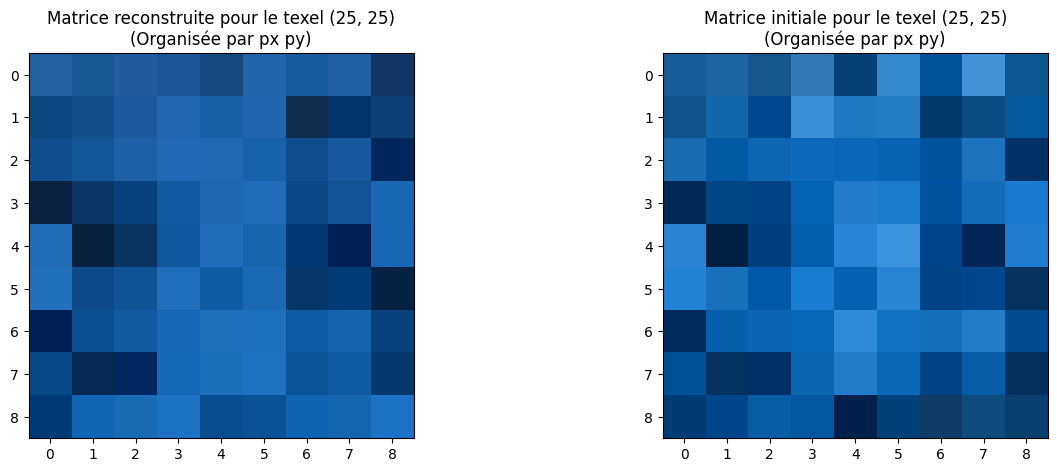

(Stereo) Différence absolue entre la matrice reconstruite, et la matrice initiale: 0.025


In [58]:
latent_vector = encoder_model_light_ste.predict(input_train_batch_2d_ste)[0]  # (8,) c'est le vecteur latent pour le texel étudié

predicted_rgb_ste = []

for angles in light_dirs_ste:
    decoder_input = np.concatenate([latent_vector, angles])[np.newaxis, :]
    predicted_rgb = decoder_model_ste.predict(decoder_input, verbose=0)  # (1, 3)
    predicted_rgb_ste.append(predicted_rgb)

predicted_rgb_ste_np = np.array(predicted_rgb_ste, dtype=np.float32) # Forme (81, 3)
mat_s_pred = (predicted_rgb_ste_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_s_pred)
axes[1].imshow(mat_s)
axes[0].set_title(f"Matrice reconstruite pour le texel {texel_position_str}\n(Organisée par px py)")
axes[1].set_title(f"Matrice initiale pour le texel {texel_position_str}\n(Organisée par px py)")
plt.show()

# On calcule la différence absolue
mse = np.mean(np.square(predicted_rgb_ste_np - texel_stereo_np))
print(f"(Stereo) Différence absolue entre la matrice reconstruite, et la matrice initiale: {mse:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


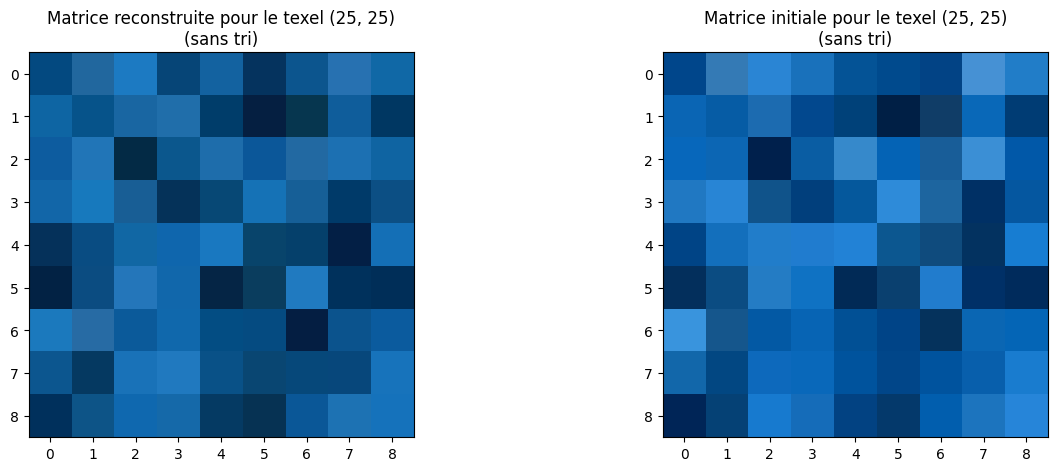

(Sans tri) Différence absolue entre la matrice reconstruite, et la matrice initiale: 0.028


In [59]:
latent_vector = encoder_model_light.predict(input_train_batch_2d)[0]  # (8,) c'est le vecteur latent pour le texel étudié

predicted_rgb_sans = []

for angles in light_dirs:
    decoder_input = np.concatenate([latent_vector, angles])[np.newaxis, :]
    predicted_rgb = decoder_model.predict(decoder_input, verbose=0)  # (1, 3)
    predicted_rgb_sans.append(predicted_rgb)

predicted_rgb_np = np.array(predicted_rgb_sans, dtype=np.float32) # Forme (81, 3)
mat_pred = (predicted_rgb_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_pred)
axes[1].imshow(mat)
axes[0].set_title(f"Matrice reconstruite pour le texel {texel_position_str}\n(sans tri)")
axes[1].set_title(f"Matrice initiale pour le texel {texel_position_str}\n(sans tri)")
plt.show()

# On calcule la différence absolue
mse = np.mean(np.square(predicted_rgb_np - texel_sans_np))
print(f"(Sans tri) Différence absolue entre la matrice reconstruite, et la matrice initiale: {mse:.3f}")
